Saving hybrid_composites_data.csv to hybrid_composites_data.csv

🐉 Dragonfly Optimization Results
Generation Found: 83
A: High → 7.761
B: High → 11.608
C: Low → 68.734
Flexural Strength (F): 43.603
Impact Strength (I): 45.463


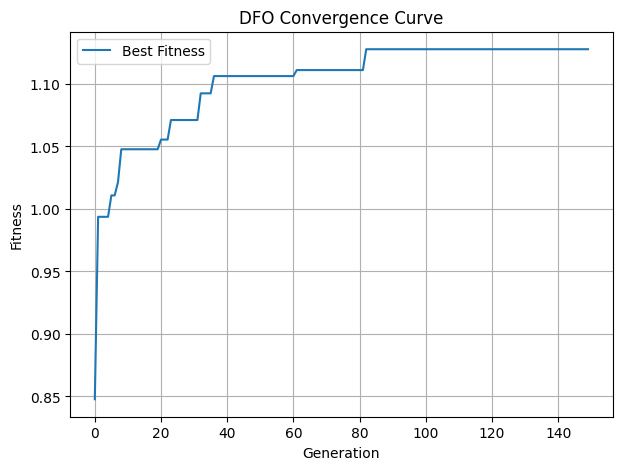

In [3]:
# --- Imports ---
import pandas as pd
import numpy as np
import random
from dataclasses import dataclass
from google.colab import files
import matplotlib.pyplot as plt

# --- Upload dataset ---
uploaded = files.upload()  # choose hybrid_composites_data.csv
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# --- Models ---
def flexural_strength(x):
    A, B, C = x[:,0], x[:,1], x[:,2]
    return (74.7266 - 11.4637*A + 1.9746*B - 0.3258*C +
            1.1282*A**2 - 0.0566*B**2 + 0.0014*C**2 -
            0.1125*A*B - 0.0022*A*C + 0.0015*B*C)

def impact_strength(x):
    A, B, C = x[:,0], x[:,1], x[:,2]
    return (12.1564 + 5.7193*A + 1.9796*B + 0.0062*C -
            0.1261*A**2 - 0.0342*B**2 + 0.0004*C**2 -
            0.0576*A*B - 0.0263*A*C - 0.0061*B*C)

# --- Factor Ranges ---
factors = ["A","B","C"]
ranges = {}
for col in factors:
    mn, mx = df[col].min(), df[col].max()
    mid = (mn+mx)/2
    ranges[col] = {
        "low": (mn, mid),
        "medium": (mn + (mx-mn)/4, mx - (mx-mn)/4),
        "high": (mid, mx)
    }

# --- Helpers ---
def genome_to_values(genome, rng):
    mapping = ["low", "medium", "high"]
    vals = []
    for gi, col in zip(genome, factors):
        low, high = ranges[col][mapping[gi]]
        vals.append(rng.uniform(low, high))
    return np.array(vals, dtype=float)

def normalize(values, vmin, vmax):
    return (values - vmin)/(vmax-vmin) if vmax > vmin else np.zeros_like(values)

# --- DFO Implementation ---
@dataclass
class DFOParams:
    pop_size:int = 30
    generations:int = 150
    weight_F:float = 0.5
    weight_I:float = 0.5
    dim:int = 3
    lb:int = 0          # 0=Low, 1=Medium, 2=High
    ub:int = 2
    step_max:float = 0.5
    seed:int = 42

def run_dfo(params:DFOParams):
    rng = np.random.default_rng(params.seed)

    # --- Population initialization ---
    pop = rng.integers(params.lb, params.ub+1, (params.pop_size, params.dim))
    vel = np.zeros_like(pop, dtype=float)

    # Normalization reference (all possible genomes)
    all_genomes = [[i,j,k] for i in range(3) for j in range(3) for k in range(3)]
    X_all = np.array([genome_to_values(g, rng) for g in all_genomes])
    F_all, I_all = flexural_strength(X_all), impact_strength(X_all)
    F_min, F_max = F_all.min(), F_all.max()
    I_min, I_max = I_all.min(), I_all.max()

    # Track best and worst
    best_solution = None
    best_fitness = -1
    best_gen = -1
    convergence_curve = []

    for gen in range(params.generations):
        # --- Evaluate fitness ---
        X = np.array([genome_to_values(g, rng) for g in pop])
        F, I = flexural_strength(X), impact_strength(X)
        F_norm, I_norm = normalize(F, F_min, F_max), normalize(I, I_min, I_max)
        fitness = params.weight_F * F_norm + params.weight_I * I_norm

        # Update global best/worst
        best_idx, worst_idx = np.argmax(fitness), np.argmin(fitness)
        if fitness[best_idx] > best_fitness:
            best_fitness = fitness[best_idx]
            best_solution = (F[best_idx], I[best_idx], pop[best_idx].copy(),
                             genome_to_values(pop[best_idx], rng))
            best_gen = gen+1

        food = pop[best_idx].astype(float)    # best (food source)
        enemy = pop[worst_idx].astype(float)  # worst (enemy)

        # --- Update each dragonfly ---
        new_pop = []
        for i in range(params.pop_size):
            Xi = pop[i].astype(float)

            # Neighbors = all others
            neighbors = np.delete(pop, i, axis=0).astype(float)
            if len(neighbors) == 0:
                neighbors = np.array([Xi])

            # Separation, Alignment, Cohesion
            sep = -np.sum(neighbors - Xi, axis=0)
            align = np.mean(neighbors - Xi, axis=0)
            coh = np.mean(neighbors, axis=0) - Xi

            # Attraction to food, distraction from enemy
            atf = food - Xi
            dfe = enemy + Xi

            # Weights
            w_sep, w_align, w_coh, w_atf, w_dfe = 0.1, 0.1, 0.1, 2.0, 2.0

            # Update velocity (step vector)
            vel[i] = (w_sep*sep + w_align*align + w_coh*coh +
                      w_atf*atf + w_dfe*dfe)

            # Limit step size
            step = np.clip(vel[i], -params.step_max, params.step_max)

            # Update position
            Xi_new = Xi + step

            # Discretize back to genome space [0,1,2]
            Xi_new = np.clip(np.round(Xi_new), params.lb, params.ub).astype(int)
            new_pop.append(Xi_new)

        pop = np.array(new_pop)
        convergence_curve.append(best_fitness)

    return best_solution, best_gen, convergence_curve

# --- Run DFO ---
params = DFOParams()
(best_F, best_I, best_genome, best_values), gen, curve = run_dfo(params)

mapping = ["Low","Medium","High"]
print("\n🐉 Dragonfly Optimization Results")
print(f"Generation Found: {gen}")
print(f"A: {mapping[best_genome[0]]} → {best_values[0]:.3f}")
print(f"B: {mapping[best_genome[1]]} → {best_values[1]:.3f}")
print(f"C: {mapping[best_genome[2]]} → {best_values[2]:.3f}")
print(f"Flexural Strength (F): {best_F:.3f}")
print(f"Impact Strength (I): {best_I:.3f}")

# --- Convergence Plot ---
plt.figure(figsize=(7,5))
plt.plot(curve, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("DFO Convergence Curve")
plt.legend()
plt.grid(True)
plt.show()
